In [1]:
import pandas as pd
import json
import os
import math
from openai import OpenAI
from geopy.distance import geodesic

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
openai_api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api_key)

In [3]:
interventions = pd.read_csv('interventions.csv')
interventions_dict = json.loads(interventions.to_json(orient='records'))

In [4]:
def flatten_data(records):
    flattened_records = []
    for record in records:
        nested_str = record.pop('origxml')
        nested = json.loads(nested_str)
        flattened_record = {**record, **nested}
        flattened_records.append(flattened_record)
    return flattened_records

In [5]:
flattened_data = flatten_data(interventions_dict)
df = pd.DataFrame(flattened_data)

In [6]:
df_urgent = df[df['urgent'] == 1]
df_urgent['urgent'].value_counts()

urgent
1    2888
Name: count, dtype: int64

In [7]:
prompt = """
Je rol is die van een geotagger. Je ontvangt een korte tekst die mogelijk verwijst naar een fysieke locatie. Jouw taak is om deze locatie te identificeren en te classificeren. De locatieverwijzing zal waarschijnlijk geen expliciete naam van een stad of land zijn, maar eerder een beschrijvende term gerelateerd aan nabijheid. De locatieverwijzingen vallen onder één van de volgende drie categorieën:

Categorieën van locatieverwijzingen:
    1. Gebouwkenmerk: Bijvoorbeeld "op het derde verdiep", "alleenstaand huis".
    2. Vindbaar op Google Maps: Bijvoorbeeld "naast tankstation", "tegenover de kerk".
    3. Andere: Bijvoorbeeld "aan een rondpunt", "afrit snelweg".

Taken:
    Analyseer de tekst om de geotag te vinden.
    Classificeer de geotag volgens de bovengenoemde categorieën en geef de index van de categorie.
    Indien een numerieke afstand wordt genoemd bij de geotag, zet deze om in meters.
    Als er geen locatieverwijzing is, antwoord dan met "X".

Antwoordformaat: Indien een geotag is gevonden, geef je antwoord in de vorm van "categorie:geotag:afstand". Als er geen afstand is vermeld, gebruik "categorie:geotag:X". Als er geen geotag is gevonden, antwoord dan met "X". Gebruik de volgende indexen voor de categorieën: 1: Gebouwkenmerk, 2: Vindbaar op Google Maps, 3: Andere.

Voorbeeld: Gegeven de tekst "aan gulf tankstation, auto staat in brand, grijze Mercedes, staat 3 m van de pompen, enkel rook", zou jouw antwoord moeten zijn: "2:gulf tankstation:3".
"""

In [8]:
def geotag_text(info):
    user_prompt= f'Dit is de tekst die je moet analyseren: {info}'
    return client.chat.completions.create(
        model="gpt-4o",
        max_tokens=25,
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": user_prompt},
        ],
    )

In [9]:
df_geotags = pd.DataFrame(columns=['id', 'output'])

In [ ]:
for i, row in df_urgent.iterrows():
    info = row['Info']
    response = geotag_text(info)
    content = response.choices[0].message.content
    new_row = pd.DataFrame([{'id': row['id'], 'output': content}])
    df_geotags = pd.concat([df_geotags, new_row], ignore_index=True)

In [11]:
df_geotags.shape

(2888, 2)

In [12]:
df_geotags.to_csv('geotags_gpt4.csv', index=False)

In [ ]:
df = pd.read_csv('geotags_gpt4.csv')

In [ ]:
df['output'] = df['output'].str.strip('\'"')

In [29]:
split_cols = df['output'].str.split(':', expand=True)

df['categorie'] = split_cols[0]
df['geotag'] = split_cols[1]
df['afstand'] = split_cols[2]

df.drop(columns=['output'], inplace=True)
df.shape

(2888, 4)

In [ ]:
df.to_csv('geotags_processed.csv', index=False)

In [ ]:
geotags_processed = pd.read_csv('geotags_processed.csv')

In [ ]:
df_merged = geotags_processed[geotags_processed['categorie'].isin(['1', '2', '3', 'X'])]

In [ ]:
def stratified_sample(df, category_col, sample_size):
    category_proportions = df[category_col].value_counts(normalize=True)
    samples_per_category = (category_proportions * sample_size).round().astype(int)

    stratified_samples = [
        df[df[category_col] == category].sample(n=num_samples, random_state=1, replace=True)
        for category, num_samples in samples_per_category.items()
    ]
    
    stratified_df = pd.concat(stratified_samples).reset_index(drop=True)
    return stratified_df

In [ ]:
import math

sample_size = math.ceil(df_merged.shape[0]*0.05)
print(sample_size)
sampled_df = stratified_sample(df_merged, 'categorie', sample_size)
sampled_df.shape

In [ ]:
df = pd.DataFrame(pd.read_excel("sampled_geotags_ingevuld.xlsx"))

In [3]:
df['true_label'] = df['true_label'].astype(str)
df['categorie'] = df['categorie'].astype(str)

In [4]:
df_copy = df.copy()
df_copy['true_label'] = df_copy['true_label'].replace(['1', '2', '3'], 'Geotag')
df_copy['categorie'] = df_copy['categorie'].replace(['1', '2', '3'], 'Geotag')
df_copy['true_label'].value_counts()

true_label
Geotag    78
X         67
Name: count, dtype: int64

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(df['categorie'], df['true_label'])

array([[27,  8,  2, 13],
       [ 0, 14,  0,  2],
       [ 1,  5,  8,  3],
       [ 5,  5,  3, 49]], dtype=int64)

In [8]:
accuracy_score(df_copy['true_label'], df_copy['categorie'])

0.7862068965517242

In [9]:
accuracy_score(df['true_label'], df['categorie'])

0.6758620689655173

In [13]:
df_new = df_copy[df_copy['true_label'] != 'X']
df_new.shape

(145, 6)

In [ ]:
accuracy_score(df['true_label'], df['categorie'])

In [11]:
accuracy_score(df['true_label'], df['categorie'], normalize=True)

0.6758620689655173

In [6]:
df_copy['true_label'] = df_copy['true_label'].replace('X', 'Geen geotag')
df_copy['categorie'] = df_copy['categorie'].replace('X', 'Geen geotag')

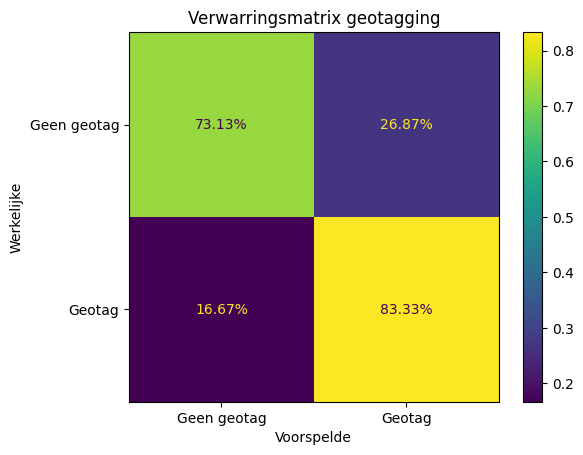

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

unique_labels = sorted(df_copy['categorie'].unique())
ConfusionMatrixDisplay.from_predictions(df_copy['true_label'], df_copy['categorie'], labels=unique_labels, normalize="true", values_format=".2%")
plt.title('Verwarringsmatrix geotagging')
plt.xlabel('Voorspelde')
plt.ylabel('Werkelijke')
plt.show()

In [43]:
df['true_label'] = df['true_label'].replace('X', 'Geen geotag')
df['categorie'] = df['categorie'].replace('X', 'Geen geotag')
df['true_label'] = df['true_label'].replace('1', 'Cat 1')
df['categorie'] = df['categorie'].replace('1', 'Cat 1')
df['true_label'] = df['true_label'].replace('2', 'Cat 2')
df['categorie'] = df['categorie'].replace('2', 'Cat 2')
df['true_label'] = df['true_label'].replace('3', 'Cat 3')
df['categorie'] = df['categorie'].replace('3', 'Cat 3')

In [44]:
df['true_label'].value_counts()

true_label
Geen geotag    67
Cat 1          33
Cat 2          32
Cat 3          13
Name: count, dtype: int64

In [45]:
df['categorie'].value_counts()

categorie
Geen geotag    62
Cat 1          50
Cat 3          17
Cat 2          16
Name: count, dtype: int64

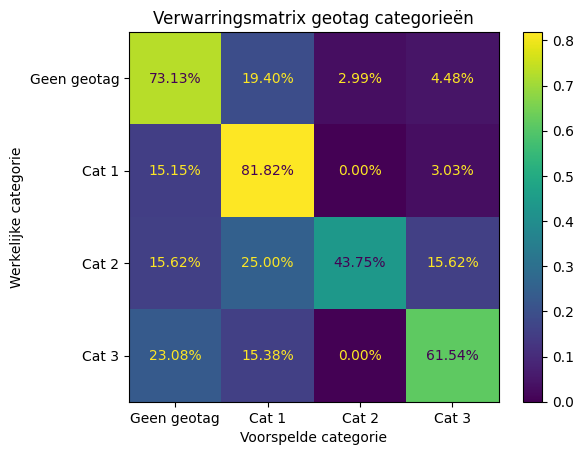

In [62]:
unique_labels = ['Geen geotag', 'Cat 1', 'Cat 2', 'Cat 3']
#disp = ConfusionMatrixDisplay(confusion_matrix(df['true_label'], df['categorie'], labels=unique_labels, normalize="true"), display_labels=unique_labels).plot()
ConfusionMatrixDisplay.from_predictions(df['true_label'], df['categorie'], labels=unique_labels, normalize="true", values_format=".2%")
plt.title('Verwarringsmatrix geotag categorieën')
plt.xlabel('Voorspelde categorie')
plt.ylabel('Werkelijke categorie')
plt.show()